In [2]:
# === Import Libraries ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, SimpleRNN
from sklearn.preprocessing import MinMaxScaler

In [3]:
# === Load and Merge Datasets ===
data_files = [
    r"C:\Users\DELL\Desktop\PYTHON\Major btech project scripts\Delhi.csv",
    r"C:\Users\DELL\Desktop\PYTHON\Major btech project scripts\Chennai.csv",
    r"C:\Users\DELL\Desktop\PYTHON\Major btech project scripts\Kolkata.csv",
    r"C:\Users\DELL\Desktop\PYTHON\Major btech project scripts\Mumbai.csv"
]

dataframes = [pd.read_csv(file) for file in data_files]
data = pd.concat(dataframes, ignore_index=True)

In [4]:
data

,YEAR,MO,DY,ALLSKY_SFC_SW_DWN,T2M,RH2M,WS10M,PRECTOTCORR
0,2020,12,31,2.47,10.78,39.56,3.13,0.00
1,2021,1,1,1.97,13.36,31.89,1.53,0.00
2,2021,1,2,1.11,13.50,53.98,2.43,7.36
3,2021,1,3,0.74,15.79,87.44,3.94,18.79
4,2021,1,4,2.16,17.43,76.50,2.86,0.12
...,...,...,...,...,...,...,...,...
5843,2024,12,27,3.98,23.32,81.35,2.68,0.01
5844,2024,12,28,4.06,23.93,79.10,2.44,0.48
5845,2024,12,29,4.24,24.68,73.57,2.69,0.04
5846,2024,12,30,4.39,24.62,69.71,3.09,0.00


In [5]:
# Replace -999 values with NaN, then impute with column means
data.replace(-999, np.nan, inplace=True)
data.fillna(data.select_dtypes(include=[np.number]).mean(), inplace=True)


# === Feature Scaling ===
scaler = MinMaxScaler()
features = ['T2M', 'RH2M', 'WS10M', 'PRECTOTCORR']
data[features] = scaler.fit_transform(data[features])

In [6]:
# Define input (X) and output (y)
X = data[features]
y = data['ALLSKY_SFC_SW_DWN']

In [7]:

# Split into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [8]:
# === Model Training Functions ===
def train_random_forest(X_train, y_train):
    model = RandomForestRegressor(random_state=42)
    model.fit(X_train, y_train)
    return model


def train_xgboost(X_train, y_train):
    model = XGBRegressor(random_state=42)
    model.fit(X_train, y_train)
    return model


def train_lstm(X_train, y_train, epochs=10, batch_size=32):
    model = Sequential([
        LSTM(50, activation='relu', input_shape=(X_train.shape[1], 1)),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train.values.reshape(-1, X_train.shape[1], 1),
              y_train, epochs=epochs, batch_size=batch_size, verbose=0)
    return model


def train_rnn(X_train, y_train, epochs=10, batch_size=32):
    model = Sequential([
        SimpleRNN(50, activation='relu', input_shape=(X_train.shape[1], 1)),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train.values.reshape(-1, X_train.shape[1], 1),
              y_train, epochs=epochs, batch_size=batch_size, verbose=0)
    return model

In [9]:
# === Evaluation Function (including Beta Score Placeholder) ===
def evaluate_regression(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    beta_score = (0.7 * mae + 0.3 * rmse)
    return mae, rmse, r2, beta_score

In [10]:
# === Train Models ===
rf_model = train_random_forest(X_train, y_train)
xgb_model = train_xgboost(X_train, y_train)
lstm_model = train_lstm(X_train, y_train)
rnn_model = train_rnn(X_train, y_train)


C:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [11]:
# === Predictions ===
rf_preds = rf_model.predict(X_test)
xgb_preds = xgb_model.predict(X_test)
lstm_preds = lstm_model.predict(X_test.values.reshape(-1, X_test.shape[1], 1)).flatten()
rnn_preds = rnn_model.predict(X_test.values.reshape(-1, X_test.shape[1], 1)).flatten()

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


In [12]:
# === Evaluate Models ===
rf_metrics = evaluate_regression(y_test, rf_preds)
xgb_metrics = evaluate_regression(y_test, xgb_preds)
lstm_metrics = evaluate_regression(y_test, lstm_preds)
rnn_metrics = evaluate_regression(y_test, rnn_preds)

In [13]:
# === Organize Results into DataFrame for Plotting ===
results_df = pd.DataFrame({
    'Model': ['Random Forest', 'XGBoost', 'LSTM', 'RNN'],
    'MAE': [rf_metrics[0], xgb_metrics[0], lstm_metrics[0], rnn_metrics[0]],
    'RMSE': [rf_metrics[1], xgb_metrics[1], lstm_metrics[1], rnn_metrics[1]],
    'R2 Score': [rf_metrics[2], xgb_metrics[2], lstm_metrics[2], rnn_metrics[2]],
    'Beta Score': [rf_metrics[3], xgb_metrics[3], lstm_metrics[3], rnn_metrics[3]]
})


In [14]:
results_df

,Model,MAE,RMSE,R2 Score,Beta Score
0,Random Forest,0.706846,0.929396,0.598629,0.773611
1,XGBoost,0.732339,0.959987,0.571771,0.800633
2,LSTM,0.927236,1.145263,0.390526,0.992644
3,RNN,0.885380,1.076468,0.461548,0.942706


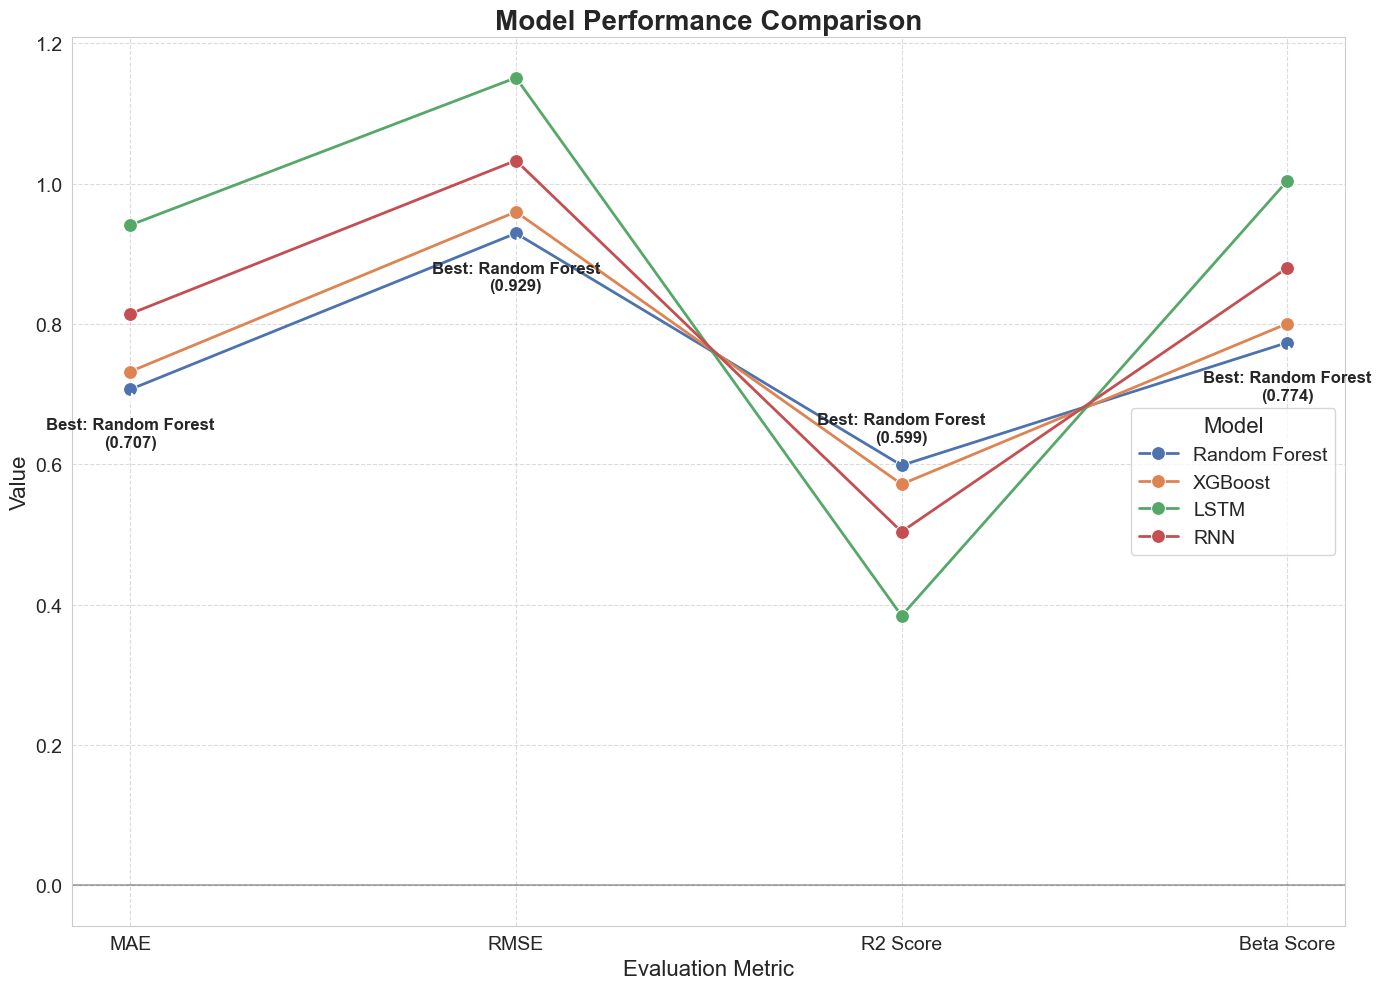

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Create DataFrame with the model performance metrics
results_df = pd.DataFrame({
    'Model': ['Random Forest', 'XGBoost', 'LSTM', 'RNN'],
    'MAE': [0.706846, 0.732339, 0.941095, 0.814651],
    'RMSE': [0.929396, 0.959987, 1.151142, 1.033105],
    'R2 Score': [0.598629, 0.571771, 0.384252, 0.504054],
    'Beta Score': [0.773611, 0.800633, 1.004109, 0.880187]
})

# Convert DataFrame to long format for seaborn
results_long = pd.melt(results_df, id_vars=['Model'], 
                        value_vars=['MAE', 'RMSE', 'R2 Score', 'Beta Score'],
                        var_name='Metric', value_name='Value')

# Set up the figure and customize style
plt.figure(figsize=(14, 10))
sns.set_style("whitegrid")
sns.set_palette("deep")

# Create line plot
ax = sns.lineplot(data=results_long, x='Metric', y='Value', 
                  hue='Model', marker='o', markersize=10, linewidth=2)

# Add labels and title
plt.title('Model Performance Comparison', fontsize=20, fontweight='bold')
plt.xlabel('Evaluation Metric', fontsize=16)
plt.ylabel('Value', fontsize=16)

# Customize the plot
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(title='Model', fontsize=14, title_fontsize=16)
plt.grid(True, linestyle='--', alpha=0.7)

# For the R2 Score, higher is better, so let's annotate the best model
for metric in ['MAE', 'RMSE', 'R2 Score', 'Beta Score']:
    subset = results_long[results_long['Metric'] == metric]
    
    # For R2 Score, higher is better
    if metric == 'R2 Score':
        best_idx = subset['Value'].idxmax()
        best_model = subset.loc[best_idx, 'Model']
        best_value = subset.loc[best_idx, 'Value']
        plt.annotate(f'Best: {best_model}\n({best_value:.3f})', 
                    xy=(metric, best_value),
                    xytext=(0, 15), textcoords='offset points',
                    ha='center', va='bottom',
                    fontsize=12, fontweight='bold',
                    arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.2'))
    # For others, lower is better
    else:
        best_idx = subset['Value'].idxmin()
        best_model = subset.loc[best_idx, 'Model']
        best_value = subset.loc[best_idx, 'Value']
        plt.annotate(f'Best: {best_model}\n({best_value:.3f})', 
                    xy=(metric, best_value),
                    xytext=(0, -20), textcoords='offset points',
                    ha='center', va='top',
                    fontsize=12, fontweight='bold',
                    arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.2'))

# Add a horizontal line at y=0 for reference
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)

# Tight layout and show plot
plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


<Figure size 1600x1000 with 0 Axes>

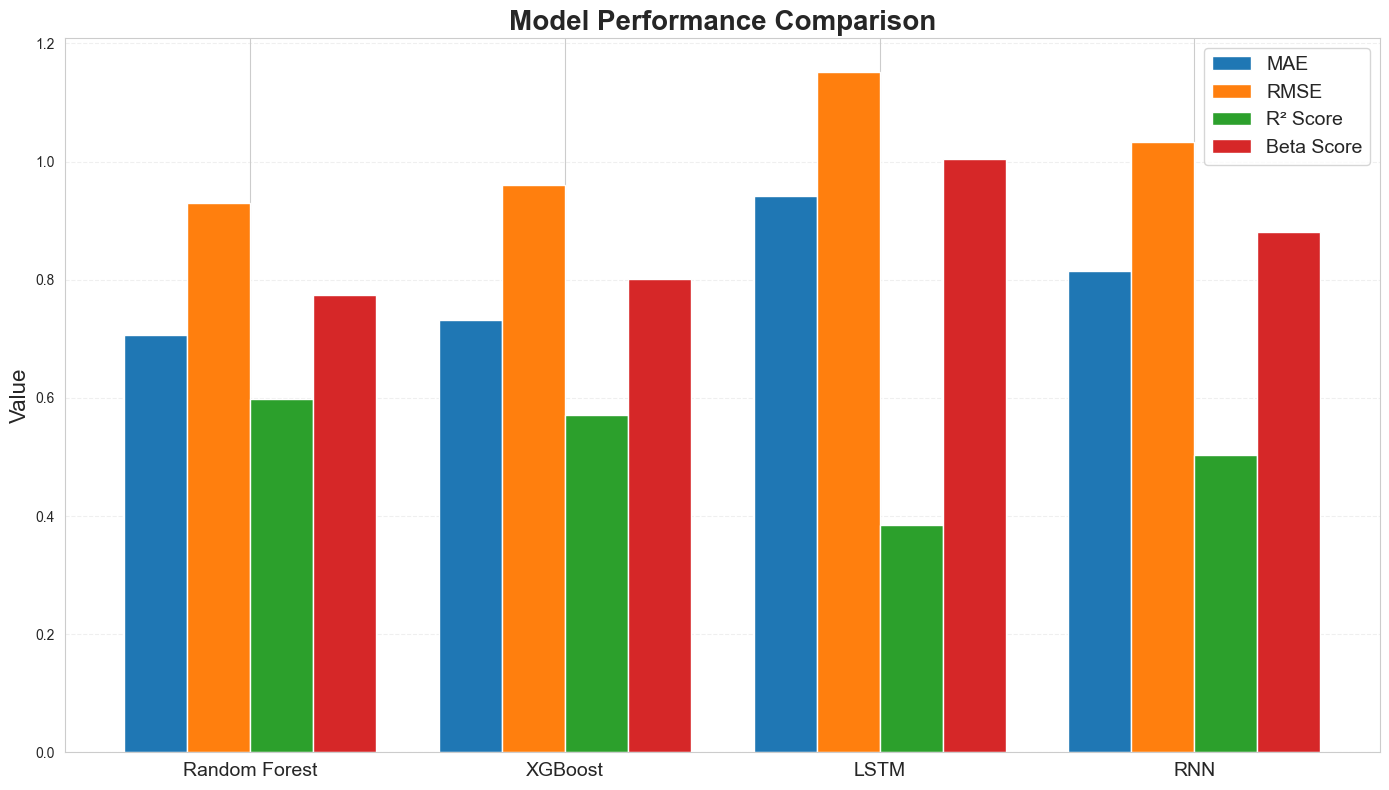

In [16]:
# Create a grouped bar chart
plt.figure(figsize=(16, 10))
x = np.arange(len(results_df['Model']))
width = 0.2

fig, ax = plt.subplots(figsize=(14, 8))
ax.bar(x - width*1.5, results_df['MAE'], width, label='MAE', color='#1f77b4')
ax.bar(x - width/2, results_df['RMSE'], width, label='RMSE', color='#ff7f0e')
ax.bar(x + width/2, results_df['R2 Score'], width, label='R² Score', color='#2ca02c')
ax.bar(x + width*1.5, results_df['Beta Score'], width, label='Beta Score', color='#d62728')

ax.set_title('Model Performance Comparison', fontsize=20, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(results_df['Model'], fontsize=14)
ax.set_ylabel('Value', fontsize=16)
ax.legend(fontsize=14)
ax.grid(True, linestyle='--', alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('model_comparison_bar.png', dpi=300, bbox_inches='tight')
plt.show()


In [17]:
# MAE VALUES BY CITY FOR EACH MODEL:

# === Add 'City' column before merging, if not already present ===
city_names = ['Delhi', 'Chennai', 'Kolkata', 'Mumbai']
for df, city in zip(dataframes, city_names):
    df['City'] = city
data = pd.concat(dataframes, ignore_index=True)

# ... (your preprocessing and model training code)

# === After train_test_split, get city labels for test set ===
city_labels = data.loc[X_test.index, 'City']

# === Compute MAE by city for each model ===
models = {
    'Random Forest': rf_preds,
    'XGBoost': xgb_preds,
    'LSTM': lstm_preds,
    'RNN': rnn_preds
}

mae_by_city = {model: [] for model in models}
for city in city_names:
    mask = (city_labels == city)
    for model, preds in models.items():
        mae = mean_absolute_error(y_test[mask], preds[mask])
        mae_by_city[model].append(mae)

# === Display as DataFrame ===
mae_city_df = pd.DataFrame(mae_by_city, index=city_names)
mae_city_df

,Random Forest,XGBoost,LSTM,RNN
Delhi,0.712476,0.748003,0.888234,0.797424
Chennai,0.742499,0.756172,1.096543,1.065320
Kolkata,0.665127,0.712150,0.739136,0.746717
Mumbai,0.703647,0.710450,0.972027,0.924774


In [18]:
# COMPUTATIONAL EFFICIENCY COMPARISON:
import time
import joblib
import os
import tempfile
import numpy as np

# --- Helper to measure model size in MB ---
def get_model_size_mb(model, model_type):
    with tempfile.NamedTemporaryFile(delete=False) as tmp:
        if model_type in ['Random Forest', 'XGBoost']:
            joblib.dump(model, tmp.name)
            size = os.path.getsize(tmp.name) / 1024**2
        elif model_type in ['LSTM', 'RNN']:
            model.save(tmp.name + '.h5', overwrite=True)
            size = os.path.getsize(tmp.name + '.h5') / 1024**2
        else:
            size = np.nan
    return round(size, 2)

# --- Measure training time ---
def timed_fit(model, X, y, model_type, epochs=10, batch_size=32):
    start = time.time()
    if model_type in ['LSTM', 'RNN']:
        model.fit(X.values.reshape(-1, X.shape[1], 1), y, epochs=epochs, batch_size=batch_size, verbose=0)
    else:
        model.fit(X, y)
    end = time.time()
    return end - start

# --- Measure inference time per sample ---
def timed_predict(model, X, model_type):
    X_input = X.values.reshape(-1, X.shape[1], 1) if model_type in ['LSTM', 'RNN'] else X
    start = time.time()
    preds = model.predict(X_input)
    end = time.time()
    elapsed = end - start
    time_per_sample = (elapsed / len(X)) * 1000  # ms/sample
    return time_per_sample

# --- Run timings and sizes ---
results = []
models_info = [
    ('Random Forest', RandomForestRegressor(random_state=42)),
    ('XGBoost', XGBRegressor(random_state=42)),
    ('LSTM', Sequential([LSTM(50, activation='relu', input_shape=(X_train.shape[1], 1)), Dense(1)])),
    ('RNN', Sequential([SimpleRNN(50, activation='relu', input_shape=(X_train.shape[1], 1)), Dense(1)])),
]
for name, model in models_info:
    # Compile NN models
    if name in ['LSTM', 'RNN']:
        model.compile(optimizer='adam', loss='mse')
    # Training time
    train_time = timed_fit(model, X_train, y_train, name)
    # Inference time
    infer_time = timed_predict(model, X_test, name)
    # Model size
    size_mb = get_model_size_mb(model, name)
    results.append([name, round(train_time, 2), round(infer_time, 2), size_mb])

# --- Present as DataFrame ---
efficiency_df = pd.DataFrame(results, columns=['Model', 'Training Time (s)', 'Inference Time (ms/sample)', 'Model Size (MB)'])
efficiency_df

C:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


,Model,Training Time (s),Inference Time (ms/sample),Model Size (MB)
0,Random Forest,3.72,0.06,40.29
1,XGBoost,0.32,0.00,0.39
2,LSTM,8.23,0.60,0.14
3,RNN,5.61,0.50,0.05
